In [41]:
import sys
import os

parent_dir = os.path.dirname(os.getcwd())
scripts_path = os.path.join(parent_dir, "scripts")

if scripts_path not in sys.path:
  sys.path.insert(0, scripts_path)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import base_path

In [3]:
fights_df = pd.read_csv(base_path('data/Fights.csv'))

In [4]:
# Metrics to aggregate for each fighter
metrics = ['KD', 'STR', 'TD', 'SUB', 'Ctrl', 'Sig. Str. %', 'Head_%', 'Body_%', 'Leg_%',
           'Distance_%', 'Clinch_%', 'Ground_%', 'Sub. Att', 'Rev.']

# Per-fight rows for Fighter_1
df1 = fights_df [['Fighter_1','Round'] + [f'{m}_1' for m in metrics]].rename(
    columns={'Fighter_1':'Full Name' , **{f'{m}_1' : m for m in metrics}}
)

# Per-fight rows for Fighter_2
df2 = fights_df[['Fighter_2','Round'] + [f'{m}_2' for m in metrics]].rename(
    columns={'Fighter_2': 'Full Name', **{f'{m}_2': m for m in metrics}}
)

# Concating the two dataframes and averaging each fighter's statistics
fighter_stats = (
    pd.concat([df1, df2], ignore_index=True)
      .groupby('Full Name')
      .mean().round(2)
      .sort_index()
)

In [5]:
# Merging fighters with their aggregated stats
fighters_df = pd.read_csv(base_path('data/Fighters.csv'))
# The join should be inner to avoid missing values from both sides (I trued both left and right joins)
fighters_df = fighters_df.join(fighter_stats, on='Full Name', how='inner')

In [6]:
fighters_df.dtypes

Full Name       object
Nickname        object
Ht.            float64
Wt.            float64
Reach          float64
Stance          object
W                int64
L                int64
D                int64
Belt              bool
Round          float64
KD             float64
STR            float64
TD             float64
SUB            float64
Ctrl           float64
Sig. Str. %    float64
Head_%         float64
Body_%         float64
Leg_%          float64
Distance_%     float64
Clinch_%       float64
Ground_%       float64
Sub. Att       float64
Rev.           float64
dtype: object

We may need Weight Class and Gender for recommending fighters later.

In [7]:
# Get each fighter's weightclass from the Fights dataset

fighters_weight_class = pd.concat(
    [
        fights_df[['Fighter_1', 'Weight_Class']].rename(
            columns={'Fighter_1': 'Full Name'}),
        fights_df[['Fighter_2', 'Weight_Class']].rename(
            columns={'Fighter_2': 'Full Name'})
    ]
)

fighters_weight_class['Full Name'] = fighters_weight_class['Full Name'].astype('str')

# Keep only the first occurence. Fights are already in a chronological order and we need to get last weight class a fighter played in
fighters_weight_class = fighters_weight_class.drop_duplicates(
    subset=['Full Name'], keep='first')

# Join with fighters_df to add weight class information
fighters_df = fighters_df.merge(
    fighters_weight_class, on='Full Name', how='left')

In [8]:
fighters_df['Weight_Class'].value_counts()

Weight_Class
Welterweight             433
Lightweight              409
Middleweight             329
Featherweight            260
Heavyweight              255
Bantamweight             243
Light Heavyweight        184
Flyweight                134
Women's Strawweight      100
Women's Flyweight         80
Open Weight               70
Women's Bantamweight      65
Catch Weight              25
Women's Featherweight      8
Name: count, dtype: int64

In [9]:
# Extract gender from Weight_Class
fighters_df['Gender'] = fighters_df['Weight_Class'].str.startswith('Women').map({True: 'Female', False: 'Male'}) 

In [10]:
# fighters_df.set_index('Full Name',inplace=True)
fighters_df.head()

,Full Name,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt,...,Head_%,Body_%,Leg_%,Distance_%,Clinch_%,Ground_%,Sub. Att,Rev.,Weight_Class,Gender
0,Danny Abbadi,The Assassin,5.11,155.0,NaN,Orthodox,4,6,0,False,...,0.30,0.89,0.00,0.27,0.55,0.38,0.00,0.00,Lightweight,Male
1,David Abbott,Tank,6.00,265.0,NaN,Switch,10,15,0,False,...,0.45,0.28,0.00,0.32,0.35,0.38,0.22,0.06,Heavyweight,Male
2,Hamdy Abdelwahab,The Hammer,6.20,264.0,72.0,Southpaw,6,1,0,False,...,0.41,0.78,0.80,0.46,0.22,0.49,0.00,0.00,Heavyweight,Male
3,Mansur Abdul-Malik,No Nickname,6.20,185.0,80.0,Orthodox,8,0,1,False,...,0.46,0.74,0.33,0.34,0.54,0.62,0.00,0.00,Middleweight,Male
4,Shamil Abdurakhimov,Abrek,6.30,235.0,76.0,Orthodox,20,8,0,False,...,0.37,0.42,0.68,0.30,0.38,0.38,0.09,0.00,Heavyweight,Male


The data is here let's get to preprocessing

In [11]:
na_count = fighters_df.isna().sum()
na_count[na_count > 0]

Ht.             14
Wt.             11
Reach          641
Ctrl           123
Sig. Str. %     21
dtype: int64

In [12]:
# 25% of fighters have missing Reach + I do not think Reach is important for clustering fighters into different styles
fighters_df.drop(columns='Reach',inplace=True)
# Dropping fighters with missing Ht. or Wt. (Whether they are retired or for whatever reason these values are missing)
# I think dropping them from the dataframe won't do any harm
fighters_df.dropna(subset=['Wt.','Ht.'],inplace=True)

In [13]:
# Imputing Ctrl and Significant Strikes Percentage with aggregated numbers of similar fighters
from sklearn.impute import KNNImputer
imputer = KNNImputer()
imputer.fit(fighters_df[['Ctrl','Sig. Str. %']])
fighters_df[['Ctrl','Sig. Str. %']] = imputer.transform(fighters_df[['Ctrl','Sig. Str. %']])

In [14]:
# Create a unique Fighter_Id by combining the first name, nickname, and last name
fighters_df['Fighter_Id'] = (
    fighters_df['Full Name'].str.split().str[0] + " '" + 
    fighters_df['Nickname'] + "' " + 
    fighters_df['Full Name'].str.split().str[1:].str.join(' ')
)
fighters_df['Fighter_Id'].duplicated().value_counts()
# Fighter_Id can be an index to keep track of cluster results
fighters_df.set_index('Fighter_Id',inplace=True)

In [15]:
cols_to_drop = ['Full Name','Nickname']
X = fighters_df.drop(columns=cols_to_drop)
cat_cols = ['Stance']
X['Stance']=X['Stance'].astype('category')

In [16]:
from sklearn.preprocessing import StandardScaler

# scale numeric columns in-place
num_cols = X.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [17]:
# k-means assumes continuous variables. The use on categorical data, even when one-hot encoded,is questionable.
# It sometimes works "okayish" but barely ever workd "good".

# Feature Engineering : Adding a win ratio feature
# X['Win Ratio'] = X['W'] / (X['W'] + X['L'] + X['D'])

# Finding this comment helped me improve my model
X.drop(columns=['Stance', 'Belt', 'Round', 'Weight_Class','Gender'], inplace=True)

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def train_kmeans(X):
    kms = []
    cluster_centers = []
    silhouette_scores = []
    inertias = []
    calinski_scores = []
    bouldin_scores = []

    for i in range(2, 20):
        km = KMeans(n_clusters=i,random_state=77)
        km.fit(X)
        labels = km.predict(X)
        kms.append(km)
        cluster_centers.append(km.cluster_centers_)
        silhouette_scores.append(silhouette_score(X,labels))
        inertias.append(km.inertia_)
        calinski_scores.append(calinski_harabasz_score(X,labels))
        bouldin_scores.append(davies_bouldin_score(X,labels))
        
    return [kms,bouldin_scores,inertias,silhouette_scores,calinski_scores,cluster_centers]

In [19]:
def visualize_scores(bouldin_scores,inertias,silhouette_scores,calinski_scores):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # Plot silhouette scores
    axs[0, 0].plot(range(2, 20), silhouette_scores, 'o-', color='blue')
    axs[0, 0].set_xlabel('Number of Clusters')
    axs[0, 0].set_ylabel('Silhouette Score')
    axs[0, 0].set_title('Silhouette Scores for Different Numbers of Clusters')
    axs[0, 0].grid(True)

    # Plot inertias
    axs[0, 1].plot(range(2, 20), inertias, 'o-', color='red')
    axs[0, 1].set_xlabel('Number of Clusters')
    axs[0, 1].set_ylabel('Inertia')
    axs[0, 1].set_title('Elbow Method for Optimal Number of Clusters')
    axs[0, 1].grid(True)

    # Plot Calinski-Harabasz scores
    axs[1, 0].plot(range(2, 20), calinski_scores, 'o-', color='green')
    axs[1, 0].set_xlabel('Number of Clusters')
    axs[1, 0].set_ylabel('Calinski-Harabasz Score')
    axs[1, 0].set_title('Calinski-Harabasz Scores')
    axs[1, 0].grid(True)

    # Plot Davies-Bouldin scores
    axs[1, 1].plot(range(2, 20), bouldin_scores, 'o-', color='orange')
    axs[1, 1].set_xlabel('Number of Clusters')
    axs[1, 1].set_ylabel('Davies-Bouldin Score')
    axs[1, 1].set_title('Davies-Bouldin Scores')
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

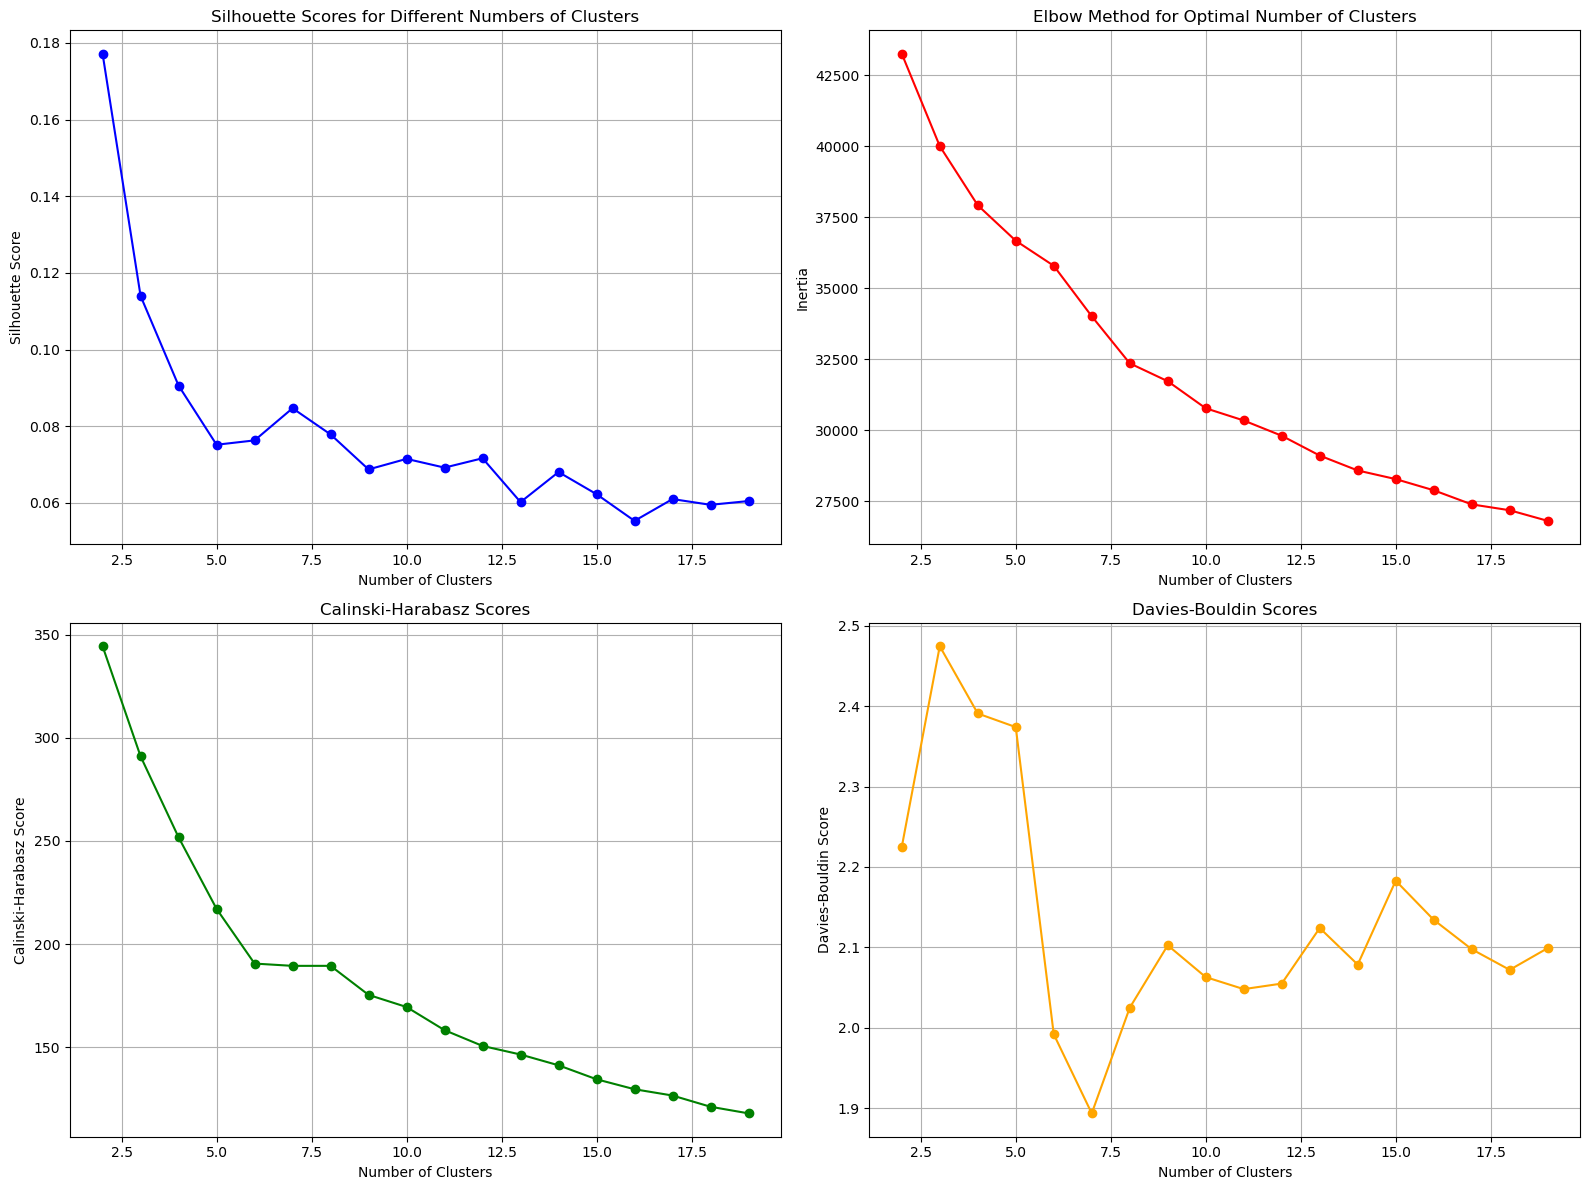

In [20]:
kms,bouldin_scores,inertias,silhouette_scores,calinski_scores,cluster_centers = train_kmeans(X)
visualize_scores(bouldin_scores,inertias,silhouette_scores,calinski_scores)


- There is no clear `Elbow` point in the Inertia graph
- Based only on the previous graphs we are so much far from having clear and separated clusters

In [21]:
import umap

# Reduce numeric features to 2D
reducer = umap.UMAP(n_components=2)
embedding = pd.DataFrame([])
embedding[['UMAP_1', 'UMAP_2']] = reducer.fit_transform(X)

In [22]:
# PCA dimensionality Reduction
from sklearn.decomposition import PCA 

pca = PCA(n_components=2,random_state=42)
pca.fit(X)
X_pca = pd.DataFrame([])
X_pca[['PCA_1','PCA_2']] = pca.transform(X)

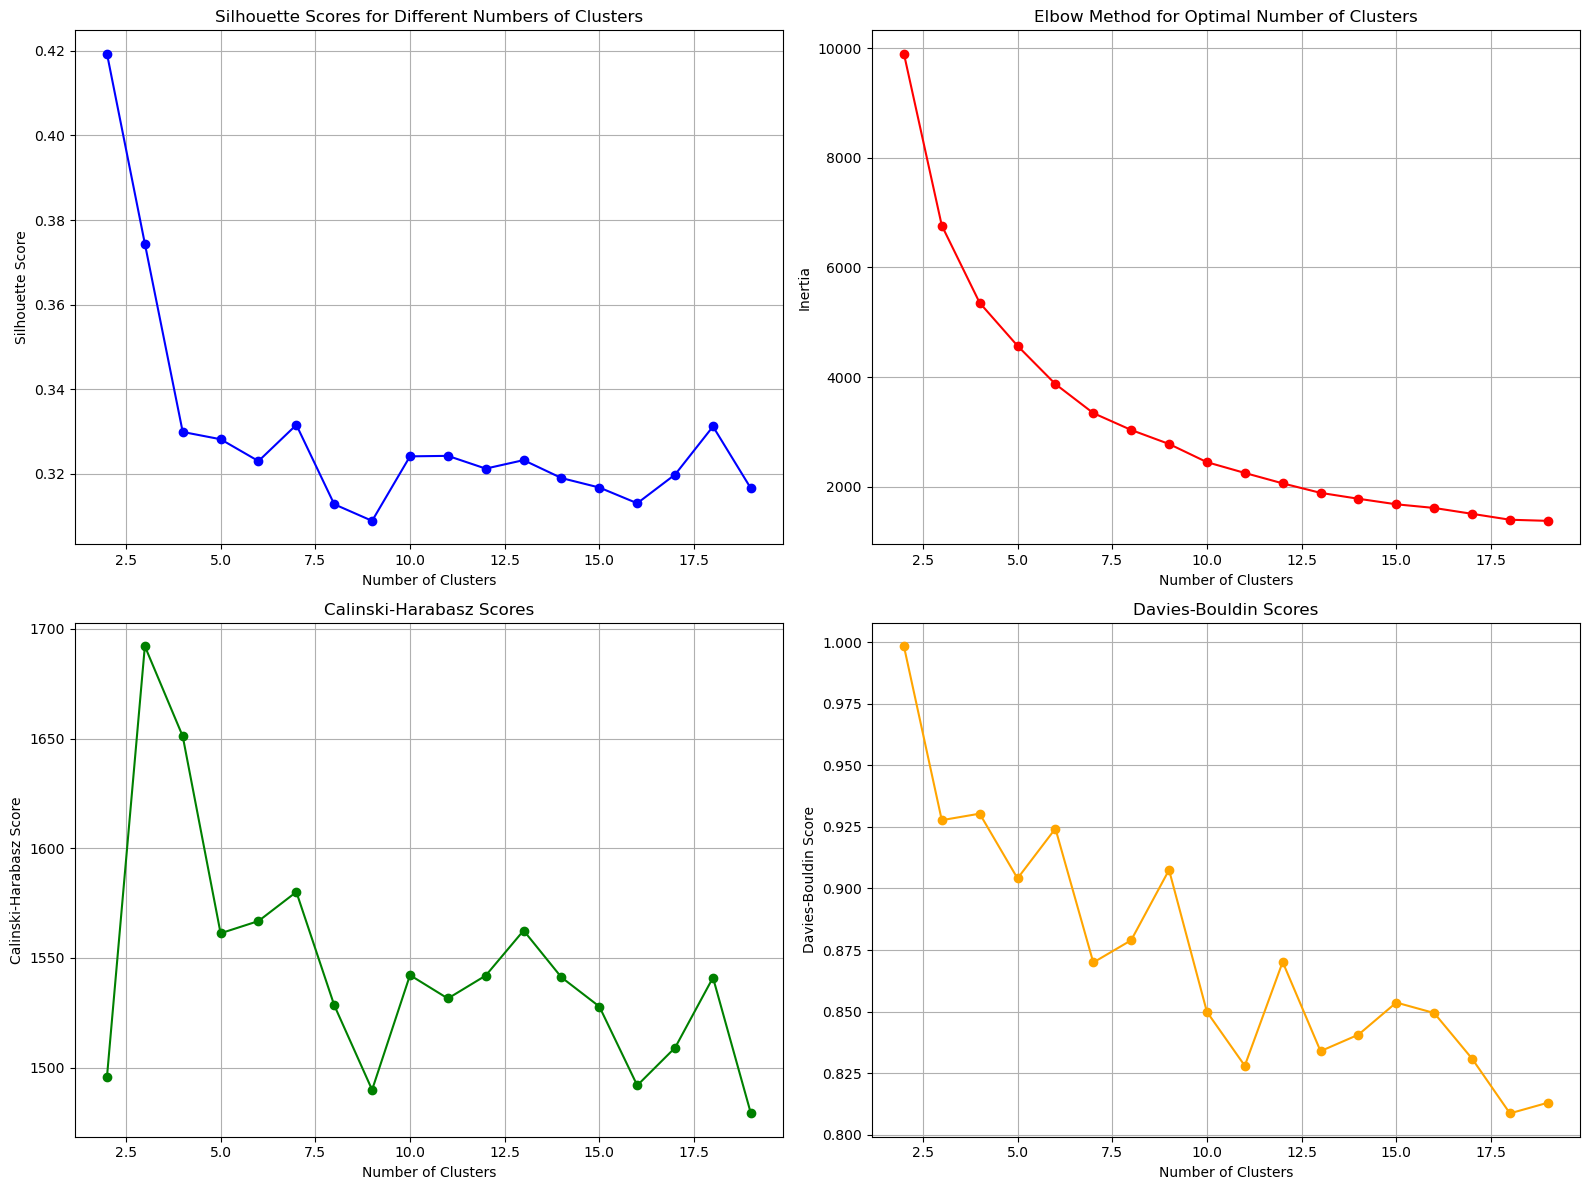

In [23]:
pca_kms,bouldin_scores,inertias,silhouette_scores,calinski_scores,cluster_centers = train_kmeans(X_pca)
pca_km = pca_kms[2]
visualize_scores(bouldin_scores,inertias,silhouette_scores,calinski_scores)

In [24]:
# This decision is based on the PCA visualizations performed .   
# We are going to continue with 4 clusters :) You can find why in the readme file
km = kms[2]
fighters_df['Cluster'] = km.predict(X)

In [25]:
# LLE
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2,n_neighbors=100,random_state=42)
X_unrolled = pd.DataFrame([])
X_unrolled[['LLE_1','LLE_2']] = lle.fit_transform(X)

In [26]:
# Print fighters of interest (That I already I know) and their cluster assignments
def explore_clusters(col):
    fighters_list = [
        'Islam Makhachev',
        'Ilia Topuria',
        'Jon Jones',
        'Daniel Cormier',
        'Max Holloway',
        'Demetrious Johnson',
        'Dricus Du Plessis',
        'Alex Pereira',
        'Magomed Ankalaev',
        'Israel Adesanya',
        'Khabib Nurmagomedov',
        'Alexander Volkanovski',
        'Merab Dvalishvili',
        'Umar Nurmagomedov',
        'Conor McGregor',
        'Francis Ngannou'
    ]
    for fighter in fighters_list : 
        print(fighter)
        print(fighters_df[fighters_df['Full Name']==fighter][col])
        print()

In [27]:
explore_clusters('Cluster')

Islam Makhachev
Fighter_Id
Islam 'No Nickname' Makhachev    1
Name: Cluster, dtype: int32

Ilia Topuria
Fighter_Id
Ilia 'El Matador' Topuria    3
Name: Cluster, dtype: int32

Jon Jones
Fighter_Id
Jon 'Bones' Jones    0
Name: Cluster, dtype: int32

Daniel Cormier
Fighter_Id
Daniel 'DC' Cormier    3
Name: Cluster, dtype: int32

Max Holloway
Fighter_Id
Max 'Blessed' Holloway    3
Name: Cluster, dtype: int32

Demetrious Johnson
Fighter_Id
Demetrious 'Mighty Mouse' Johnson    1
Name: Cluster, dtype: int32

Dricus Du Plessis
Fighter_Id
Dricus 'Stillknocks' Du Plessis    3
Name: Cluster, dtype: int32

Alex Pereira
Fighter_Id
Alex 'Poatan' Pereira    0
Name: Cluster, dtype: int32

Magomed Ankalaev
Fighter_Id
Magomed 'No Nickname' Ankalaev    0
Name: Cluster, dtype: int32

Israel Adesanya
Fighter_Id
Israel 'The Last Stylebender' Adesanya    3
Name: Cluster, dtype: int32

Khabib Nurmagomedov
Fighter_Id
Khabib 'The Eagle' Nurmagomedov    1
Name: Cluster, dtype: int32

Alexander Volkanovski
Fighte

In [28]:
def scatter_plot(x,y,hue,title,ax):
    sns.scatterplot(
        x=x, y=y,hue=fighters_df[hue].to_numpy(),
        palette='tab10',
        alpha=0.7,
        s=100, linewidth=0,ax=ax
    )
    ax.set_title(title)
    ax.legend(title='Fighting Style', bbox_to_anchor=(
        1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()

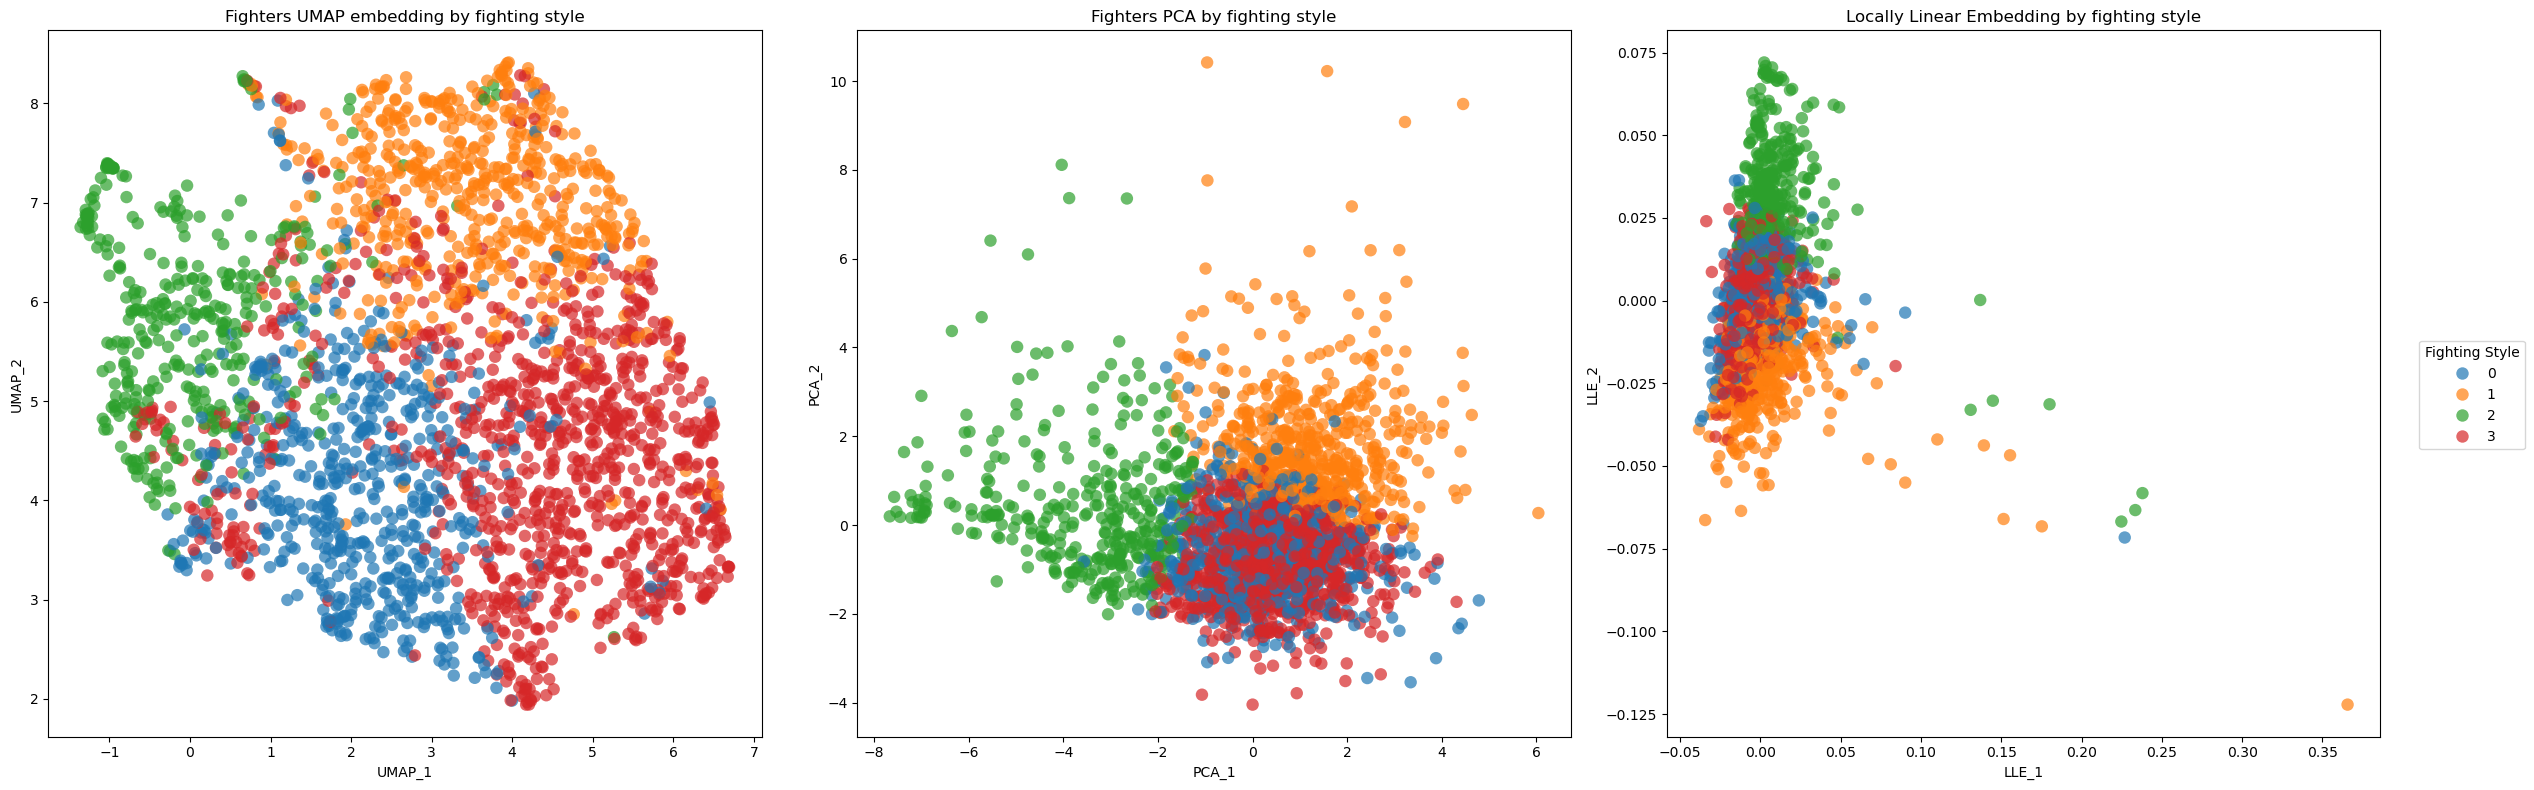

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Plot UMAP embedding
sns.scatterplot(
    x=embedding['UMAP_1'], y=embedding['UMAP_2'],
    hue=fighters_df['Cluster'].to_numpy(),
    palette='tab10',
    alpha=0.7,
    s=80, linewidth=0,
    ax=axs[0]
)
axs[0].set_title('Fighters UMAP embedding by fighting style')
axs[0].set_xlabel('UMAP_1')
axs[0].set_ylabel('UMAP_2')

# Plot PCA
sns.scatterplot(
    x=X_pca['PCA_1'], y=X_pca['PCA_2'],
    hue=fighters_df['Cluster'].to_numpy(),
    palette='tab10',
    alpha=0.7,
    s=80, linewidth=0,
    ax=axs[1]
)
axs[1].set_title('Fighters PCA by fighting style')
axs[1].set_xlabel('PCA_1')
axs[1].set_ylabel('PCA_2')

# Plot LLE
sns.scatterplot(
    x=X_unrolled['LLE_1'], y=X_unrolled['LLE_2'],
    hue=fighters_df['Cluster'].to_numpy(),
    palette='tab10',
    alpha=0.7,
    s=80, linewidth=0,
    ax=axs[2]
)
axs[2].set_title('Locally Linear Embedding by fighting style')
axs[2].set_xlabel('LLE_1')
axs[2].set_ylabel('LLE_2')

# Add a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Fighting Style', 
           bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)

# Remove individual legends from subplots
for ax in axs:
    ax.get_legend().remove()

plt.tight_layout()
plt.show()


There is no clear separated clusters. However the UMAP visualization seems to be the best, having the minimum of overlapping points

Testing the model on the reduced dataset

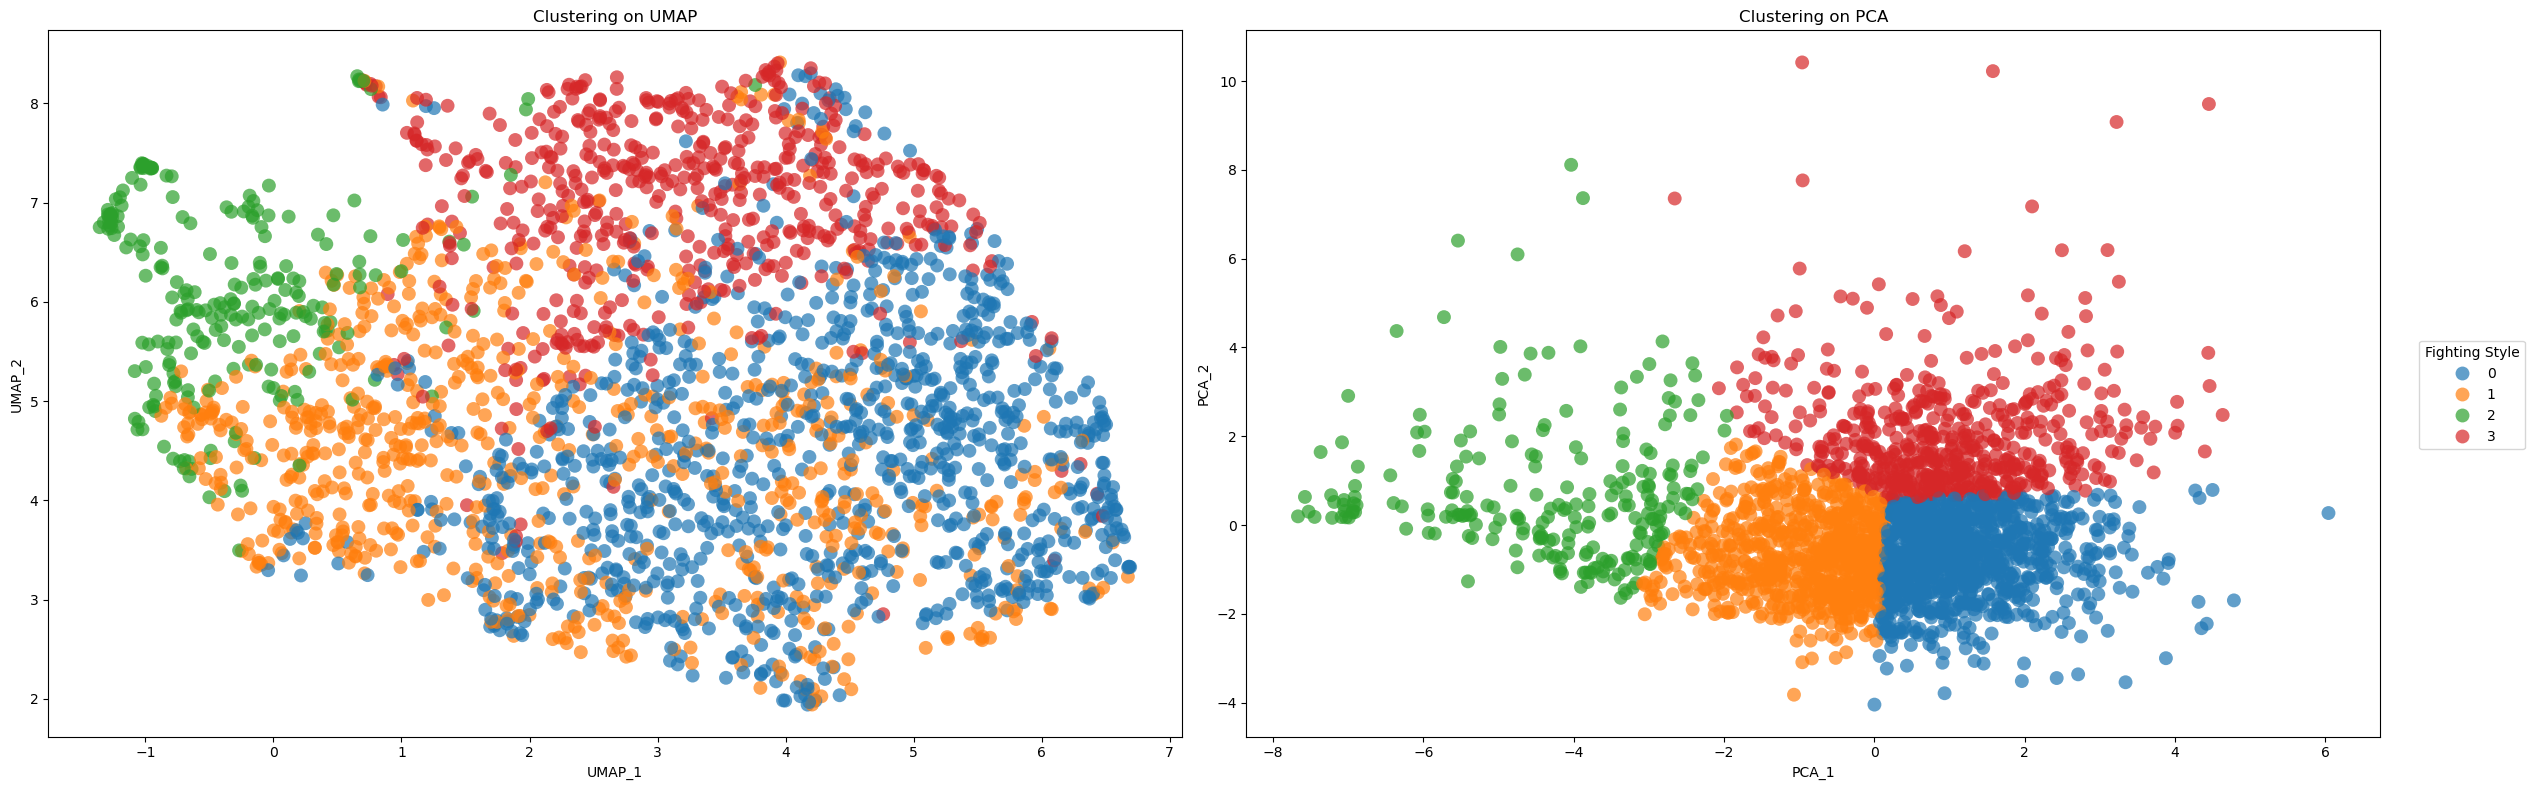

In [30]:
fig,axs = plt.subplots(1,2, figsize=(24, 8))
pca_km.fit(X_pca)
fighters_df['PCA Cluster'] = pca_km.predict(X_pca)
scatter_plot(embedding['UMAP_1'],embedding['UMAP_2'],'PCA Cluster','Clustering on UMAP',axs[0])
scatter_plot(X_pca['PCA_1'],X_pca['PCA_2'],'PCA Cluster','Clustering on PCA',axs[1])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Fighting Style', 
           bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)

for ax in axs:
    ax.get_legend().remove()

plt.tight_layout()
plt.show()

> `PCA_km` model is far more **precise** than `km`

So PCA Cluster is gonna be our Fighting Style column

In [31]:
explore_clusters('PCA Cluster')

Islam Makhachev
Fighter_Id
Islam 'No Nickname' Makhachev    3
Name: PCA Cluster, dtype: int32

Ilia Topuria
Fighter_Id
Ilia 'El Matador' Topuria    0
Name: PCA Cluster, dtype: int32

Jon Jones
Fighter_Id
Jon 'Bones' Jones    0
Name: PCA Cluster, dtype: int32

Daniel Cormier
Fighter_Id
Daniel 'DC' Cormier    0
Name: PCA Cluster, dtype: int32

Max Holloway
Fighter_Id
Max 'Blessed' Holloway    0
Name: PCA Cluster, dtype: int32

Demetrious Johnson
Fighter_Id
Demetrious 'Mighty Mouse' Johnson    3
Name: PCA Cluster, dtype: int32

Dricus Du Plessis
Fighter_Id
Dricus 'Stillknocks' Du Plessis    0
Name: PCA Cluster, dtype: int32

Alex Pereira
Fighter_Id
Alex 'Poatan' Pereira    0
Name: PCA Cluster, dtype: int32

Magomed Ankalaev
Fighter_Id
Magomed 'No Nickname' Ankalaev    0
Name: PCA Cluster, dtype: int32

Israel Adesanya
Fighter_Id
Israel 'The Last Stylebender' Adesanya    0
Name: PCA Cluster, dtype: int32

Khabib Nurmagomedov
Fighter_Id
Khabib 'The Eagle' Nurmagomedov    3
Name: PCA Cluster

Explore each cluster summary statistics to gain insights about fighting style.

In [32]:
fighters_df.columns

Index(['Full Name', 'Nickname', 'Ht.', 'Wt.', 'Stance', 'W', 'L', 'D', 'Belt',
       'Round', 'KD', 'STR', 'TD', 'SUB', 'Ctrl', 'Sig. Str. %', 'Head_%',
       'Body_%', 'Leg_%', 'Distance_%', 'Clinch_%', 'Ground_%', 'Sub. Att',
       'Rev.', 'Weight_Class', 'Gender', 'Cluster', 'PCA Cluster'],
      dtype='object')

In [33]:
def visualize_cluster_statistics(cluster):
    cols = ['W', 'L', 'D', 'Round', 'KD', 'STR', 'TD', 'SUB', 'Ctrl', 'Sig. Str. %',
            'Distance_%', 'Clinch_%', 'Ground_%', 'Sub. Att', 'Rev.', cluster]
    
    means = fighters_df[cols].select_dtypes(
        include='number').groupby(cluster).mean()

    n_cols = 3
    n_rows = (len(cols) + n_cols - 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(24, n_rows*5))
    axs = axs.flatten()

    for i, col in enumerate(cols):
        # Avoid visualizing the cluster column against itself
        if col == cluster :
            fig.delaxes(axs[i])
            continue
        
        sns.barplot(data=means, x=cluster,
                    y=cols[i], palette='viridis', hue=cluster, ax=axs[i])
        axs[i].set_title(f'{cols[i]} by {cluster}', fontsize=16)
        axs[i].set_xlabel('Clusters', fontsize=14)
        axs[i].set_ylabel(cols[i], fontsize=14)

        # Annotate bars with their values
        for p in axs[i].patches:
            axs[i].annotate(f'{p.get_height():.2f}',
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', fontsize=10)

    # Delete unused figures
    for i in range(len(cols), len(axs)):
        fig.delaxes(axs[i])

    # Remove individual legends from each subplot
    for ax in axs[:len(cols)]:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # Create a single legend for the entire figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, title=cluster, 
                bbox_to_anchor=(1.02, 0.95), loc='upper left', 
                borderaxespad=0., fontsize=12)

    plt.tight_layout(pad=3.0)
    plt.suptitle('Fighter Metrics by Cluster', fontsize=20, y=1.02)
    plt.show()

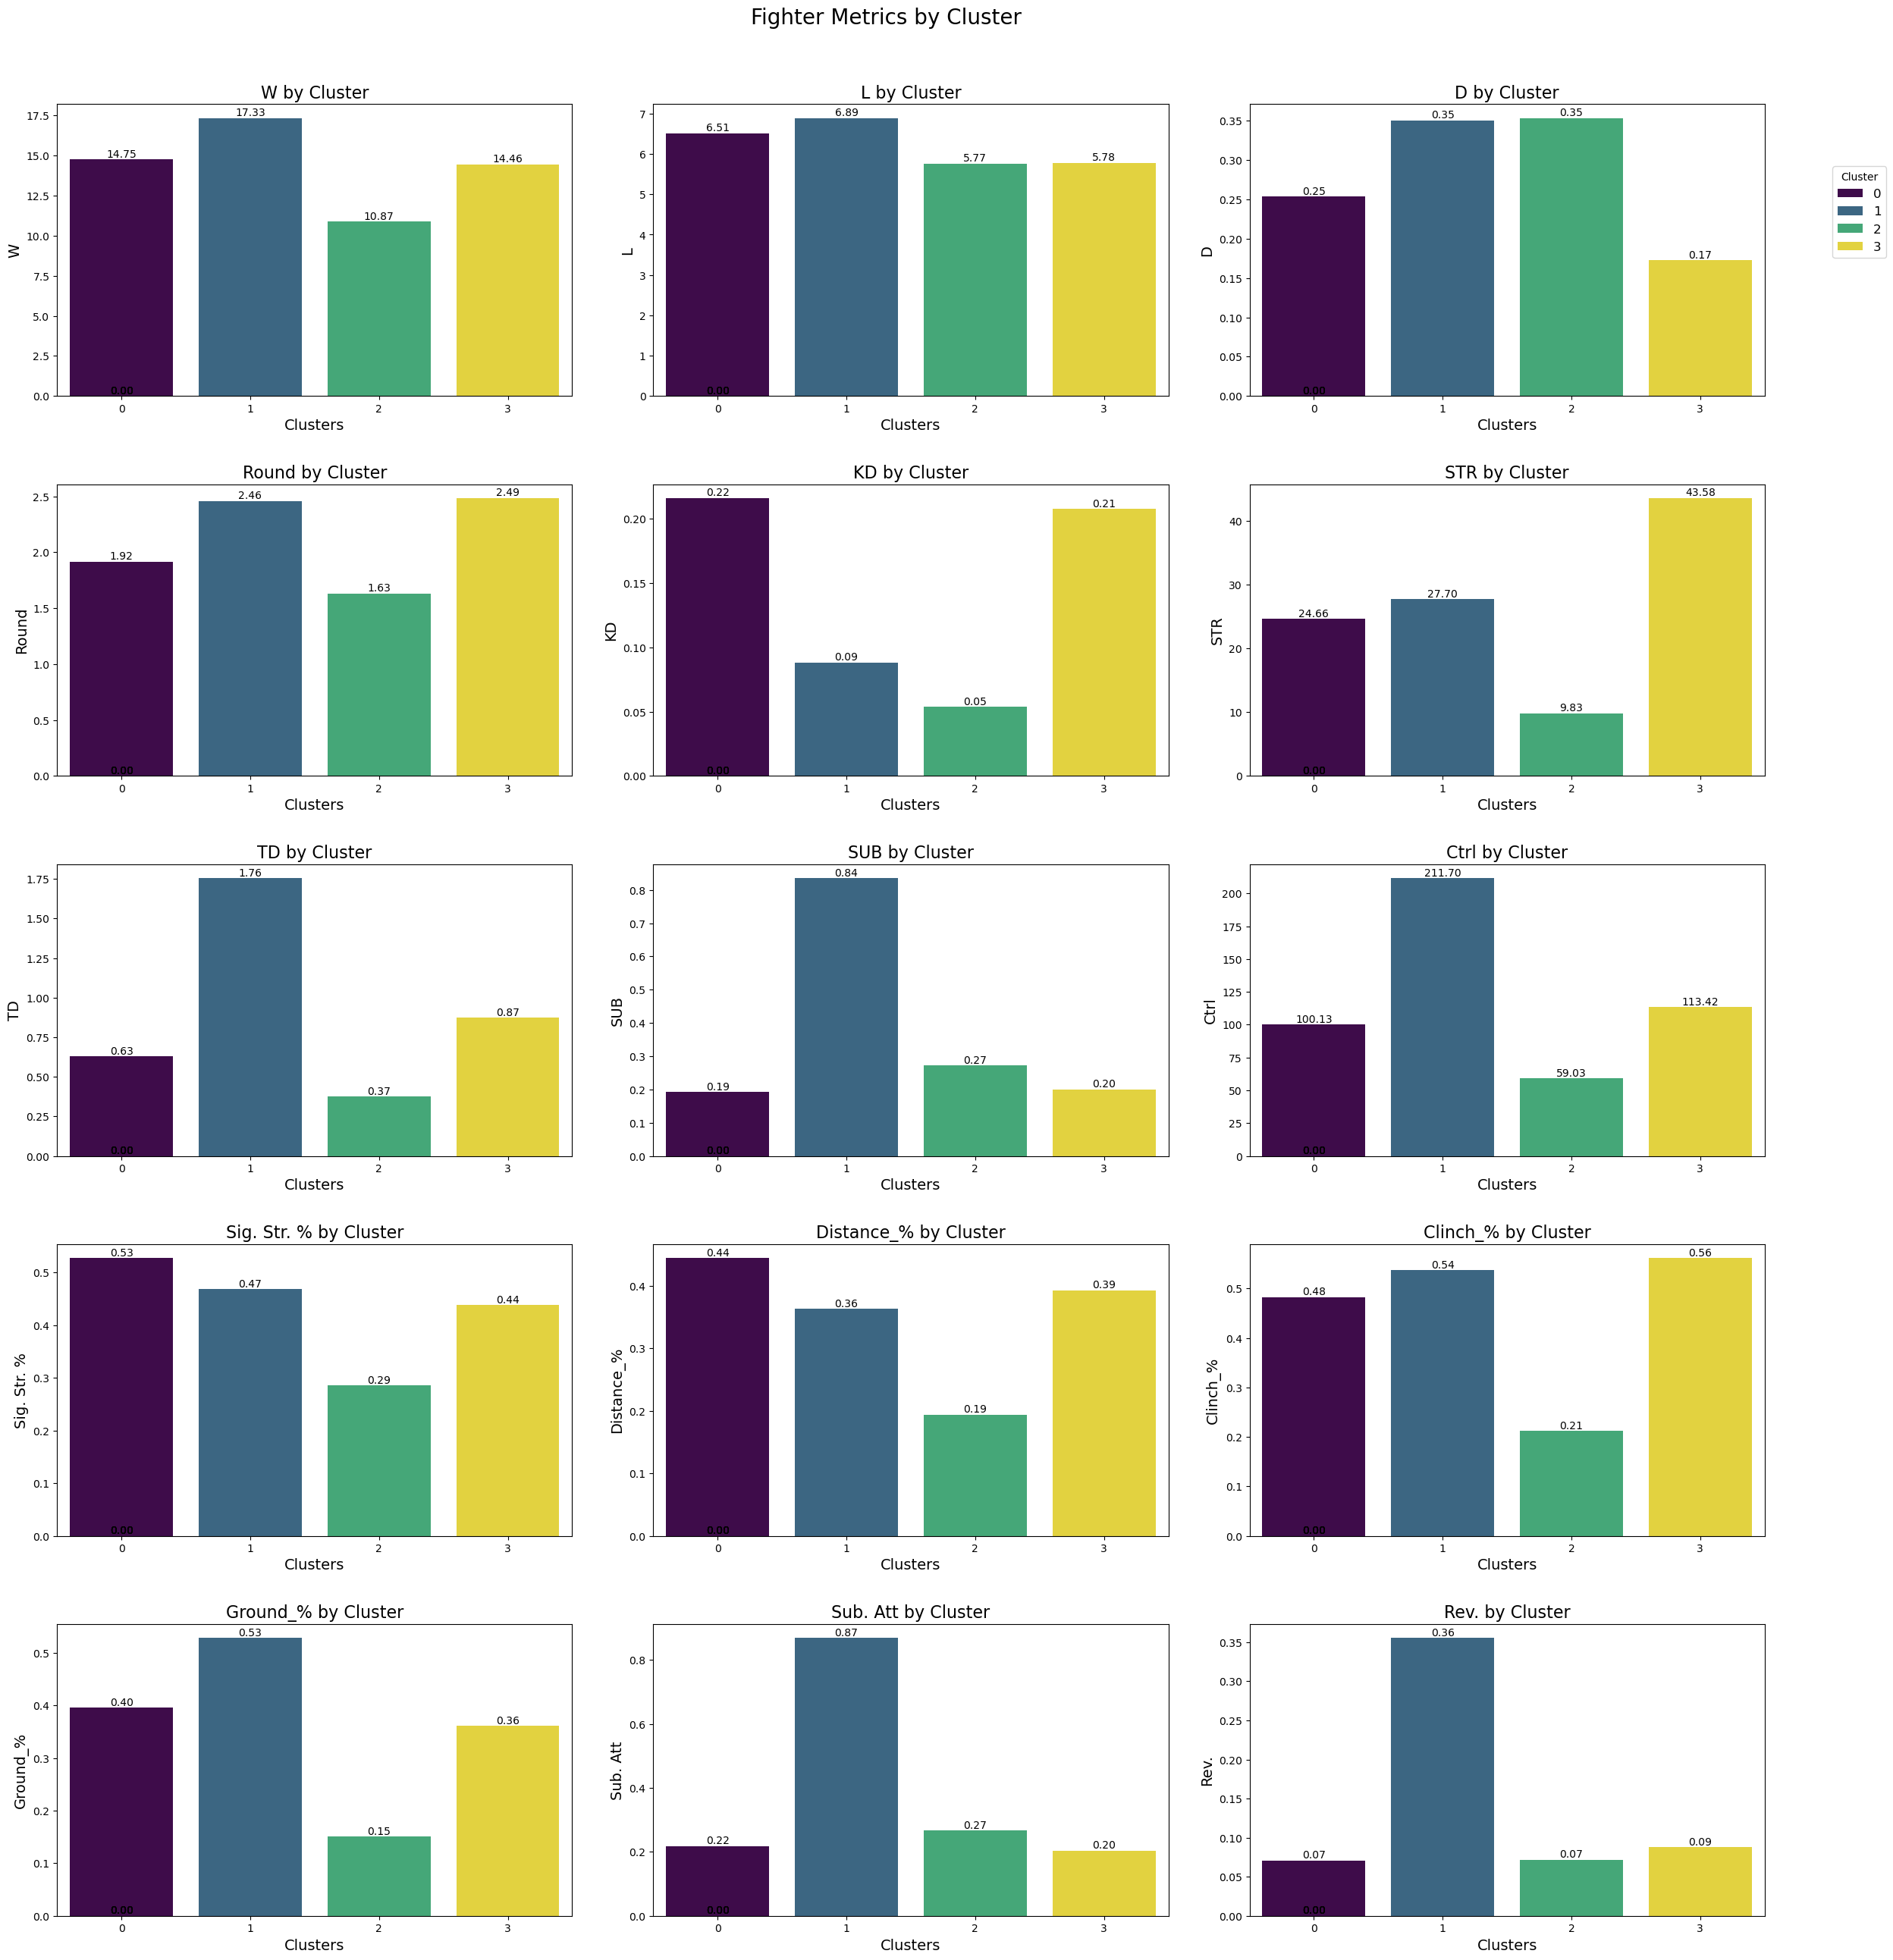

In [34]:
visualize_cluster_statistics('Cluster')

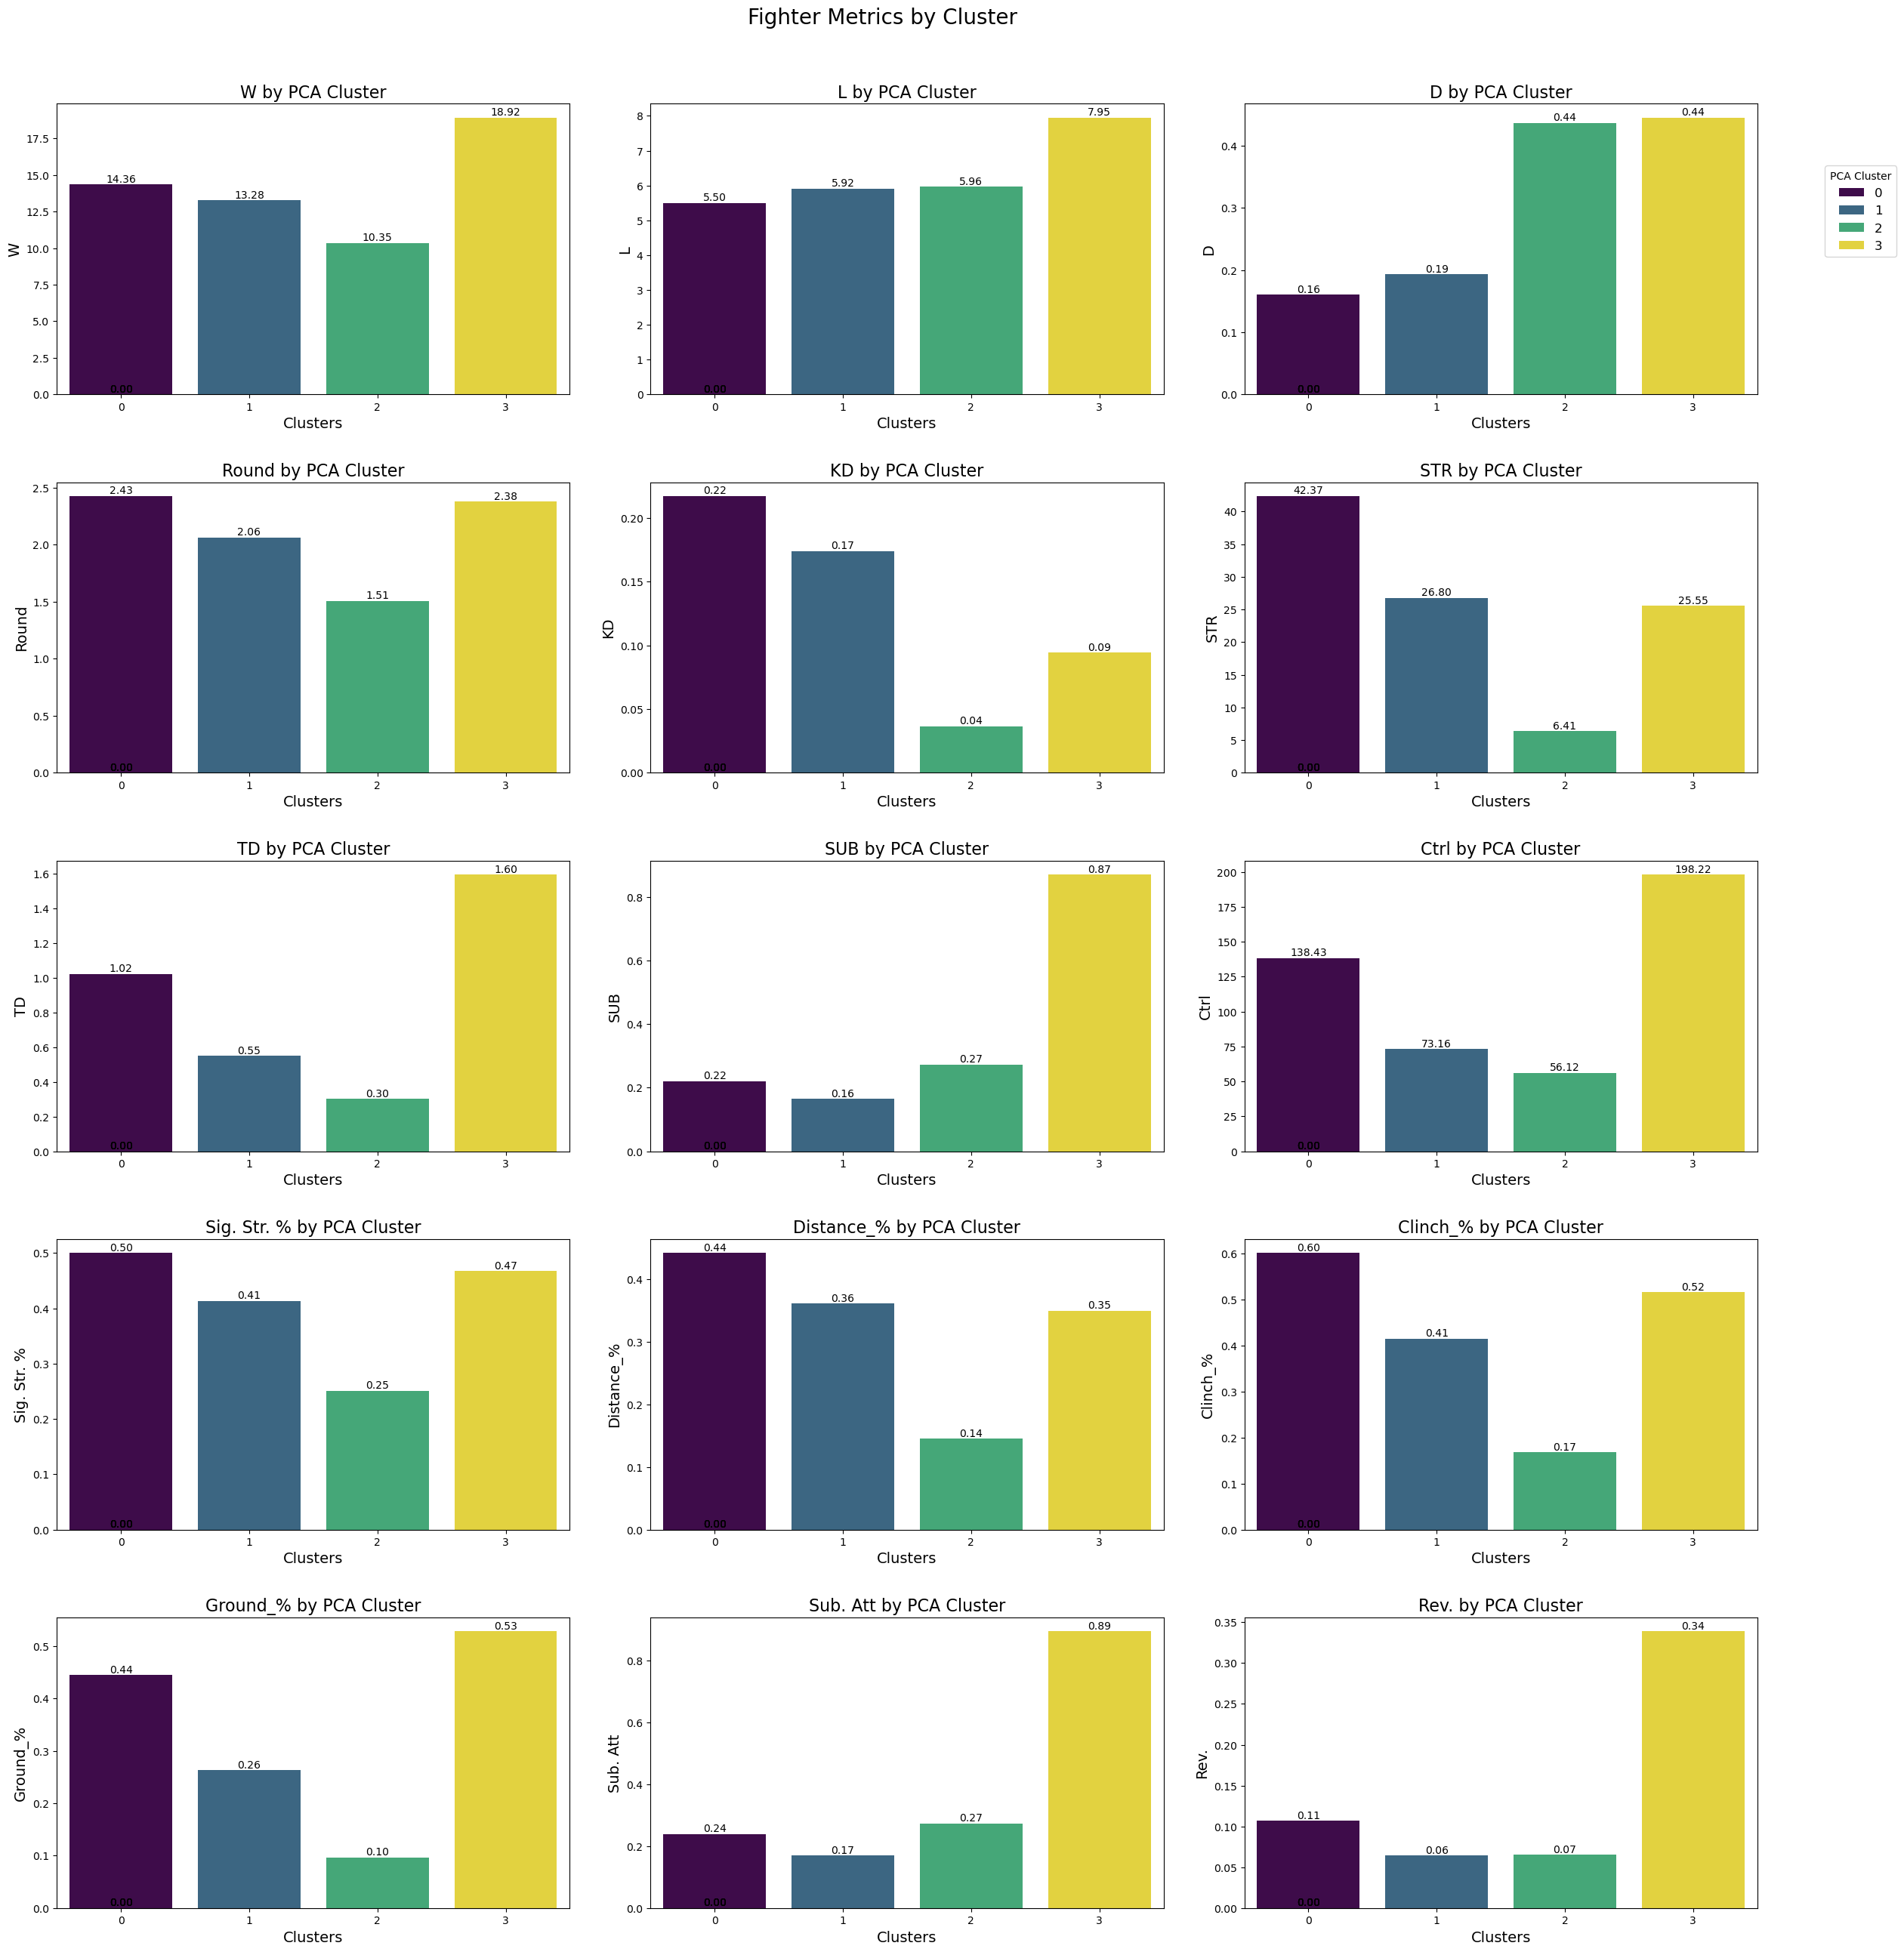

In [35]:
visualize_cluster_statistics('PCA Cluster')

# Clustering Analysis of UFC Fighter Styles

After completing these two visualizations we can confidently say:

- **Cluster 0** is for strikers: fighters in this group have the highest knockdown average, strikes and significant strikes percentage.
- **Cluster 1** is for wrestlers: fighters who tend more to the ground game having the biggest control time, submissions, ground strikes percentage, submission attempts and more features distinguishing wrestlers.
- **Cluster 2** is for hybrid fighters: having a mix of both striking & wrestling.
- **Cluster 3** has nothing significant: so they will be labeled as 'No Fighting Style'.

In [36]:
# Mapping cluster numbers to the corresponding fighting style
map_dict = {
    0 : 'Striker',
    1 : 'Wrestler',
    2 : 'Hybrid',
    3 : 'No Clear Style'
}

fighters_df['Fighting Style'] = fighters_df['PCA Cluster'].map(map_dict)

# Converting the Fighting Style column into categorical
fighters_df['Fighting Style']= fighters_df['Fighting Style'].astype('category')
# Finished working with the numerical categories.
# It's time to drop them
fighters_df.drop(columns=['Cluster','PCA Cluster'],inplace=True)

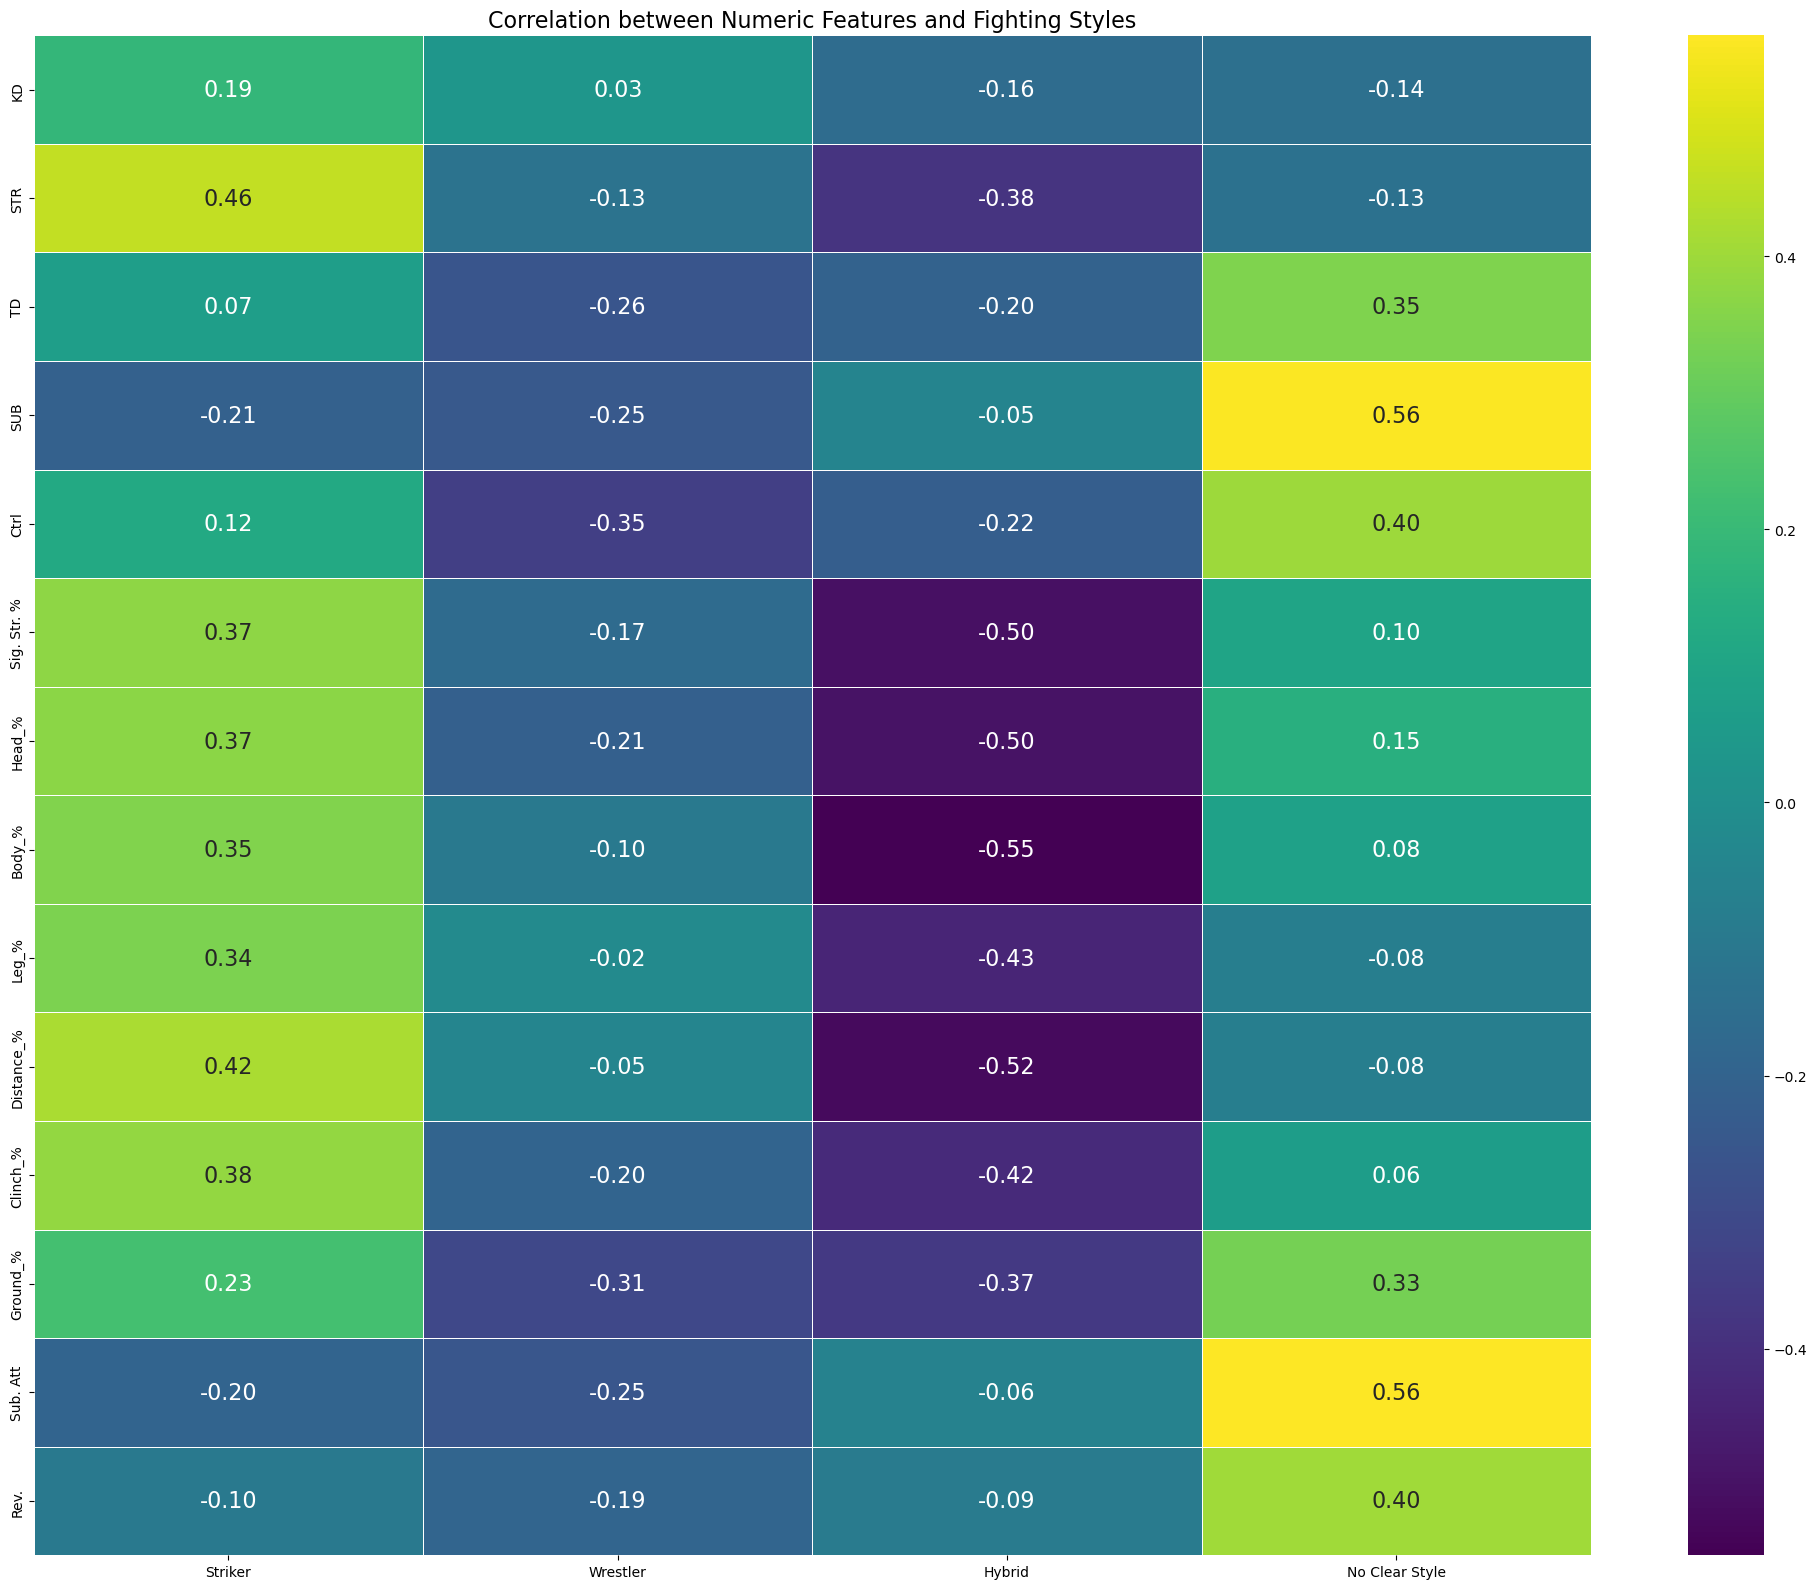

In [37]:
# Visualizing how each Fighting Style correlates to fighter's statistics
# I need to do this one hot encoding because corr method does not accept any non numerical feature 
style_dummies = pd.get_dummies(fighters_df['Fighting Style'])
numeric_with_style = pd.concat([fighters_df.select_dtypes(exclude=['object','bool','category']), style_dummies], axis=1)

# Also removing feature that the model was not trained on
no_train_cols = ['Ht.','Wt.','W','L','D','Round']
numeric_with_style.drop(columns=no_train_cols,inplace=True)



corr_matrix = numeric_with_style.corr()

plt.figure(figsize=(20, 16))
style_cols = ['Striker', 'Wrestler', 'Hybrid', 'No Clear Style']
corr_with_styles = corr_matrix.loc[numeric_with_style.select_dtypes(exclude=['object', 'category', 'bool']).columns, style_cols]

sns.heatmap(corr_with_styles, annot=True, fmt='.2f', linewidths=0.5,cmap='viridis', annot_kws={"size": 16})
plt.title('Correlation between Numeric Features and Fighting Styles', fontsize=16)
plt.tight_layout()
plt.show()


### This is absolutely amazing!

This correlation heatmap reveals a **clear relationship** between fighting styles and their defining characteristics:

- **Strikers**: Strong positive correlation with striking metrics (STR, KD, Sig. Str. %, Distance_%)
- **Wrestlers**: Highly correlated with ground game metrics (SUB, TD, Ctrl, Sub. Att, Rev.)
- **Hybrid Fighters**: Negative correlations with specialized metrics, indicating balanced skill distribution
- **No Clear Style**: Strong negative correlation with technical metrics across the board

These correlations validate our clustering approach perfectly!

In [38]:
fighters_df.head()

,Full Name,Nickname,Ht.,Wt.,Stance,W,L,D,Belt,Round,...,Body_%,Leg_%,Distance_%,Clinch_%,Ground_%,Sub. Att,Rev.,Weight_Class,Gender,Fighting Style
Fighter_Id,,,,,,,,,,,,,,,,,,,,,
Danny 'The Assassin' Abbadi,Danny Abbadi,The Assassin,5.11,155.0,Orthodox,4,6,0,False,2.00,...,0.89,0.00,0.27,0.55,0.38,0.00,0.00,Lightweight,Male,Wrestler
David 'Tank' Abbott,David Abbott,Tank,6.00,265.0,Switch,10,15,0,False,1.11,...,0.28,0.00,0.32,0.35,0.38,0.22,0.06,Heavyweight,Male,Wrestler
Hamdy 'The Hammer' Abdelwahab,Hamdy Abdelwahab,The Hammer,6.20,264.0,Southpaw,6,1,0,False,3.00,...,0.78,0.80,0.46,0.22,0.49,0.00,0.00,Heavyweight,Male,Striker
Mansur 'No Nickname' Abdul-Malik,Mansur Abdul-Malik,No Nickname,6.20,185.0,Orthodox,8,0,1,False,2.00,...,0.74,0.33,0.34,0.54,0.62,0.00,0.00,Middleweight,Male,Wrestler
Shamil 'Abrek' Abdurakhimov,Shamil Abdurakhimov,Abrek,6.30,235.0,Orthodox,20,8,0,False,2.18,...,0.42,0.68,0.30,0.38,0.38,0.09,0.00,Heavyweight,Male,Wrestler


In [39]:
fighters_df.to_csv(base_path("data/Fighters Stats.csv"))   

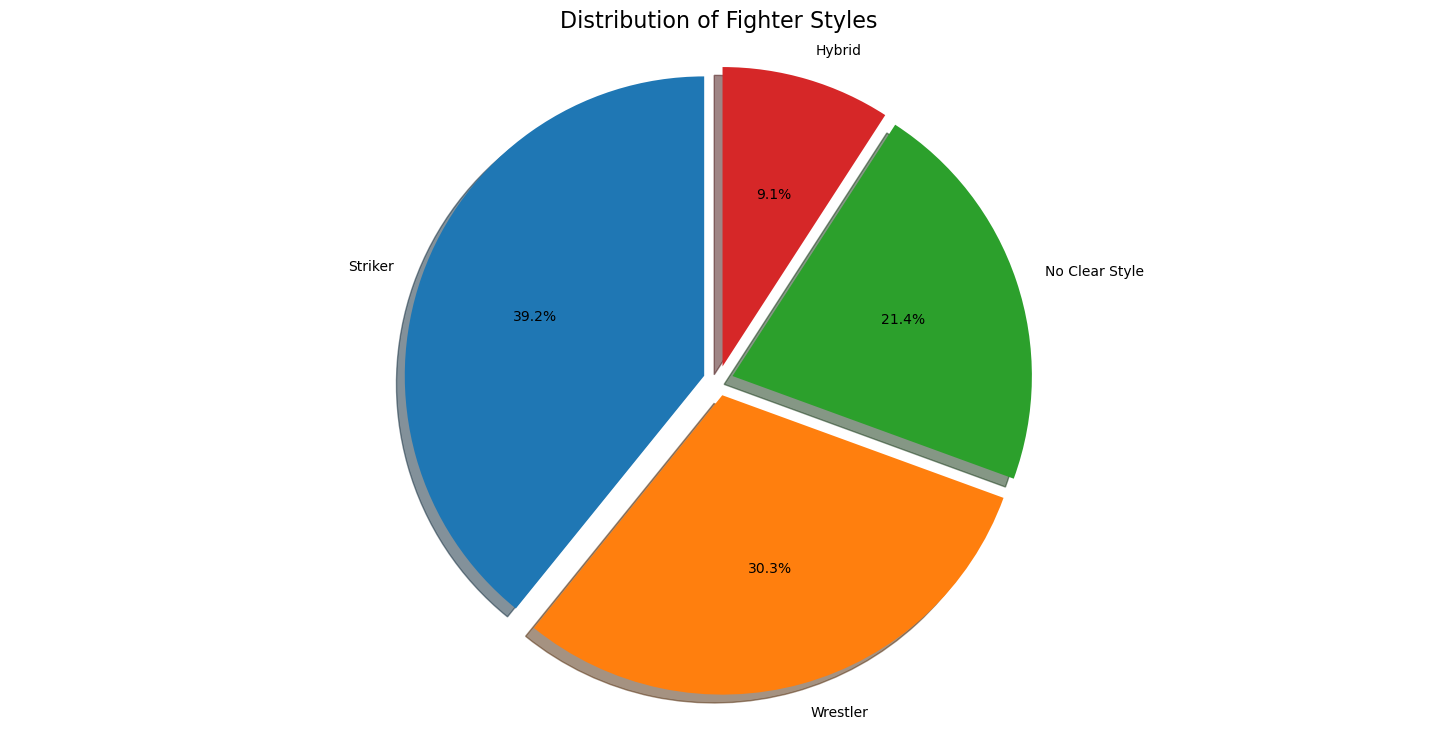

In [40]:
# Create a pie chart to visualize the distribution of fighting styles
plt.figure(figsize=(15, 8))
style_counts = fighters_df['Fighting Style'].value_counts()
colors = sns.color_palette('tab10')
plt.pie(style_counts, labels=style_counts.index, autopct='%1.1f%%', 
    startangle=90, colors=colors, shadow=True, explode=[0.05, 0.05, 0.05, 0.05])
plt.title('Distribution of Fighter Styles', fontsize=16)
plt.axis('equal') 
plt.tight_layout(pad=3)
plt.show()